In [118]:
import gc
import sys
sys.path.append('../../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [119]:
plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

In [120]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_2000.npy')

# Load created waveform images
waveform_imgs = np.load('../../../data/STEAD/created_waveform_images_subsample_2000.npy')

# Load created spectrogram images
spectrogram_imgs = np.load('../../../data/STEAD/created_spectrogram_images_subsample_2000.npy')

# Load extracted raw signals
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_2000.feather')
metadata = metadata.reset_index()

In [130]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
labels = metadata['label'].values

In [4]:
# subsample_indices = np.random.choice(len(spectrogram_imgs), size=2000)
# subsample_imgs = spectrogram_imgs[subsample_indices]
# subsample_metadata = metadata.iloc[subsample_indices]

In [131]:
metadata

,trace_name,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,...,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,chunk,weight_for_subsample,label
0,B084.PB_20111212104350_EV,PB,B084,EH,33.611570,-116.456370,1271.0,800.0,manual,0.55,...,0.5746,63.90,178.5,[15.39999962 15.5 17.10000038],[[3199.]],43:51.3,earthquake_local,1,9.706561e-07,1
1,B086.PB_20080618145426_EV,PB,B086,EH,33.557500,-116.531000,1392.0,800.0,manual,0.59,...,0.5071,56.40,330.6,[45. 46.20000076 46.29999924],[[2230.]],54:27.0,earthquake_local,1,9.706561e-07,1
2,B023.PB_20130513182210_EV,PB,B023,EH,46.111200,-123.078700,177.4,500.0,manual,0.63,...,0.9683,107.61,163.1,[12.60000038 12.10000038 11.19999981],[[3199.]],22:11.5,earthquake_local,1,9.706561e-07,1
3,B011.PB_20120724202107_EV,PB,B011,EH,48.649543,-123.448192,22.0,800.0,manual,0.76,...,0.8950,99.44,82.7,[20.39999962 26.39999962 25. ],[[3199.]],21:08.5,earthquake_local,1,9.706561e-07,1
4,B082.PB_20150914105733_EV,PB,B082,HH,33.598182,-116.596005,1374.8,799.0,autopicker,0.92,...,0.1618,17.99,123.9,[28.79999924 30.29999924 28.70000076],[[1516.]],57:35.0,earthquake_local,1,9.706561e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,XAN.IC_20180116143912_NO,IC,XAN,BH,34.031300,108.923700,630.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2018-01-16 14:39:12,noise,6,4.247619e-06,0
1996,OK048.GS_20180115012442_NO,GS,OK048,HH,36.416220,-96.943740,295.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2018-01-15 01:24:42,noise,6,4.247619e-06,0
1997,A11.CN_20180115103824_NO,CN,A11,HH,47.243100,-70.196900,55.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2018-01-15 10:38:24,noise,6,4.247619e-06,0
1998,CMOB.NC_201606271215_NO,NC,CMOB,HN,37.810420,-121.802720,743.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2016-06-27 12:15:00,noise,6,4.247619e-06,0


In [132]:
def cnn_image_preprocessing(image, image_size=(300,200)):
    image = tf.image.resize(image, image_size)  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

In [133]:
X_train, X_test, y_train, y_test = train_test_split(spectrogram_imgs, labels, random_state=0, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.25)

In [134]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [135]:
train_dataset = train_dataset.map(lambda x, y: (cnn_image_preprocessing(x), y))
val_dataset = val_dataset.map(lambda x, y: (cnn_image_preprocessing(x), y))
test_dataset = test_dataset.map(lambda x, y: (cnn_image_preprocessing(x), y))

In [136]:
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [137]:
# Callback to stop model training early if loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classification_loss',    
    mode='min',
    patience=5,                # number of epochs to wait for improvement
    restore_best_weights=True, # restore the best weights once training stops
    verbose=1                 
)

# Callback to reduce learning rate if loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_classification_loss', 
    factor=0.1,                # the factor by which the learning rate will be reduced
    patience=2,                # number of epochs to wait for improvement
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True        # save only the best model
)

callbacks = [
    early_stopping,
    reduce_lr,
    checkpoint
]

In [138]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # 10 output classes
])

In [139]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=5, callbacks=callbacks, validation_data=val_dataset)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.6240 - loss: 0.6732

/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_classification_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_classification_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 719ms/step - accuracy: 0.6260 - loss: 0.6725 - val_accuracy: 0.8480 - val_loss: 0.5759 - learning_rate: 1.0000e-06
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 718ms/step - accuracy: 0.8189 - loss: 0.5647 - val_accuracy: 0.8960 - val_loss: 0.4734 - learning_rate: 1.0000e-06
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 709ms/step - accuracy: 0.8598 - loss: 0.4707 - val_accuracy: 0.8987 - val_loss: 0.4110 - learning_rate: 1.0000e-06
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 718ms/step - accuracy: 0.9050 - loss: 0.3876 - val_accuracy: 0.9173 - val_loss: 0.3627 - learning_rate: 1.0000e-06
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 724ms/step - accuracy: 0.9094 - loss: 0.3616 - val_accuracy: 0.9307 - val_loss: 0.3249 - learning_rate: 1.0000e-06


In [140]:
model.evaluate(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9386 - loss: 0.3255


[0.3113690912723541, 0.9440000057220459]

In [145]:
def plot_training_history(history):
    # plot accuracy history, confusion matrix, roc curve
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(history.history['accuracy'], color='xkcd:cranberry', label='Training accuracy')
    ax.plot(history.history['val_accuracy'], color='xkcd:dusty blue', label='Validation accuracy')
    ax.grid(True, alpha=0.2, zorder=5)
    ax.set_title('Model Accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend()    
    plt.tight_layout()
    plt.show()

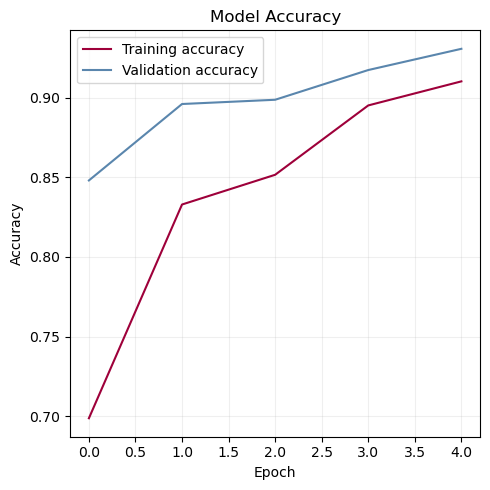

In [146]:
plot_training_history(history)

In [157]:
def evaluate_classification_model(trained_model, test_dataset):
    # Parse test labels from test dataset
    test_labels = []
    for _, labels in test_dataset:
        test_labels.append(labels.numpy())
    test_labels = np.concatenate(test_labels)
    
    print('Evaluating model on test dataset')    
    print('Finding predicted classes and probabilities')
    predicted_classes = np.argmax(model.predict(test_dataset),axis=-1) # predict the class of each image
    predicted_probs = model.predict(test_dataset) # predict the probability of each image belonging to a class
    
    accuracy = accuracy_score(test_labels,predicted_classes)
    precision = precision_score(test_labels,predicted_classes)
    recall = recall_score(test_labels,predicted_classes)
    print(f'The accuracy of the model is {accuracy}, the precision is {precision}, and the recall is {recall}.')

    # create confusion matrix
    print('Building confusion matrix')
    cm = confusion_matrix(test_labels, predicted_classes) # compare target values to predicted values and show confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not earthquake','earthquake'])

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_labels, predicted_classes)
    roc_auc = auc(fpr, tpr)  

    # plot accuracy history, confusion matrix, roc curve
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))  
    disp.plot(cmap='Blues', ax=ax1, values_format='')
    ax1.set_title('Classification CNN Results')
    ax2.plot(fpr, tpr, color='xkcd:cranberry', label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='lightgray', linestyle='--')  # Diagonal line (random classifier)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.grid(True, alpha=0.2, zorder=5)
    plt.tight_layout()
    plt.show()
    

Evaluating model on test dataset
Finding predicted classes and probabilities
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
The accuracy of the model is 0.944, the precision is 0.9829059829059829, and the recall is 0.905511811023622.
Building confusion matrix


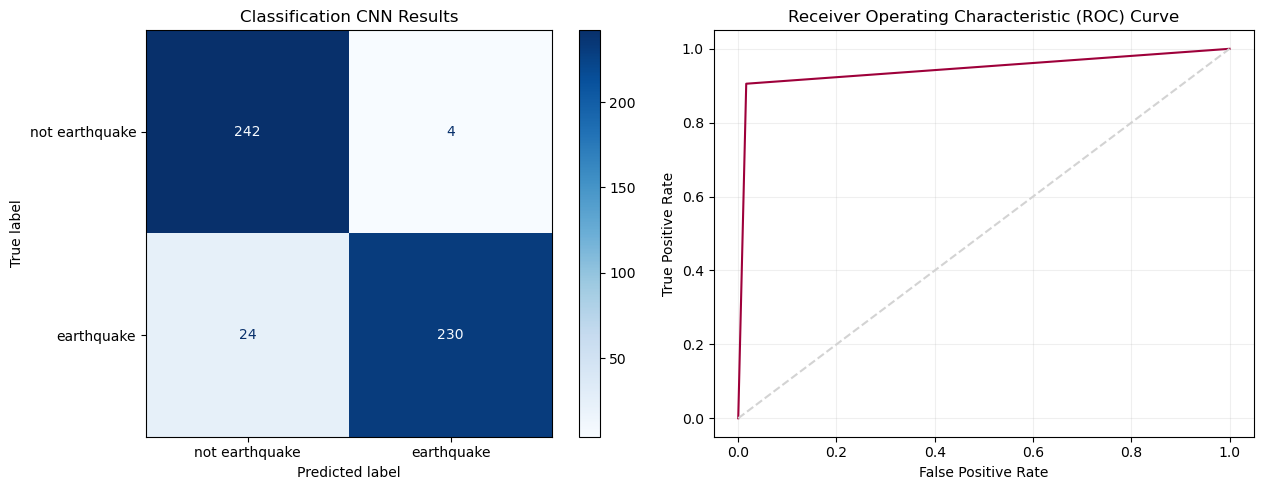

In [158]:
evaluate_classification_model(model, test_dataset)